In [1]:
import matplotlib.pyplot as plt
from wavebench.plot_utils import remove_ticks
from wavebench import wavebench_figure_path

save_path = f'{wavebench_figure_path}/dataset_demo'


In [2]:
import ml_collections
import numpy as np
import cv2
from wavebench.utils import seed_everything
import os

from wavebench import wavebench_dataset_path


medium_collection = {}

for medium in ['gaussian_lens', 'grf_isotropic', 'grf_anisotropic']:
  config = ml_collections
  config.medium_type = medium #'gaussian_random_field'

  config.domain_sidelen = 128
  config.domain_dx = 8
  # the above seetings give a domain of 1024 km x 1024 km

  config.medium_source_loc = (50, 55)
  config.medium_density = 2650
  config.pml_size = 2

  #  define properties of the propagation medium
  min_wavespeed = 1400
  max_wavespeed = 4000


  if config.medium_type == 'gaussian_lens':
    point_mass_strength = -31000
    z = np.ones((config.domain_sidelen,config.domain_sidelen))
    z[config.medium_source_loc] = point_mass_strength
    medium_sound_speed = cv2.GaussianBlur(
        z,
        ksize=(0, 0),
        sigmaX=50,
        borderType=cv2.BORDER_REPLICATE)
  elif config.medium_type == 'grf_isotropic':
    medium_sound_speed = np.fromfile(
      os.path.join(
        wavebench_dataset_path, "time_varying/wavespeed/isotropic_cp_128x128_00001.H@"),
      dtype=np.float32).reshape(128, 128)

    if config.domain_sidelen != 128:
      medium_sound_speed = interpolate(
          medium_sound_speed,
          size=[config.domain_sidelen, config.domain_sidelen],
          mode='bicubic')
  elif config.medium_type == 'grf_anisotropic':
    medium_sound_speed = np.fromfile(
      os.path.join(
        wavebench_dataset_path,
        "time_varying/wavespeed/anisotropic_cp_128x128_00001.H@"),
      dtype=np.float32).reshape(128, 128)

    if config.domain_sidelen != 128:
      medium_sound_speed = jax.image.resize(
          medium_sound_speed,
          (config.domain_sidelen, config.domain_sidelen),
          'bicubic')
  else:
    raise NotImplementedError

  medium_sound_speed -= medium_sound_speed.min()
  medium_sound_speed /= medium_sound_speed.max()

  config.medium_sound_speed = medium_sound_speed*(
  max_wavespeed - min_wavespeed) + min_wavespeed

  medium_collection[medium] = config.medium_sound_speed


## Reverse Time Continuation (RTC) dataset

In [3]:
from wavebench.dataloaders.rtc_loader import get_dataloaders_rtc_thick_lines
from wavebench.dataloaders.rtc_loader import get_dataloaders_rtc_mnist
from wavebench import wavebench_figure_path

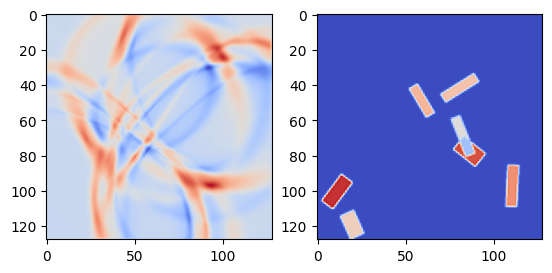

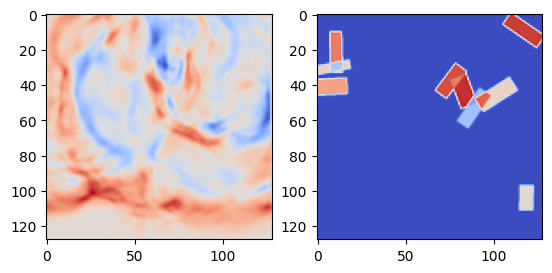

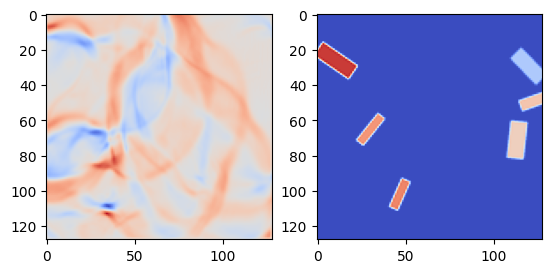

In [4]:

in_dist_rtc_loaders = {}
ood_rtc_loaders = {}


for medium_type in ['gaussian_lens', 'grf_isotropic', 'grf_anisotropic']:
  loaders = get_dataloaders_rtc_thick_lines(
    medium_type=medium_type,
  )

  idx = 1
  a, b = next(iter(loaders['train']))
  fig, axes = plt.subplots(1, 2)

  axes[0].imshow(a.squeeze().numpy(), cmap='coolwarm')
  axes[1].imshow(b.squeeze().numpy(), cmap='coolwarm')
  in_dist_rtc_loaders[medium_type] = loaders
  ood_rtc_loaders[medium_type] = get_dataloaders_rtc_mnist(
    medium_type,
    )

In [5]:
import numpy as np
from wavebench.plot_utils import plot_image


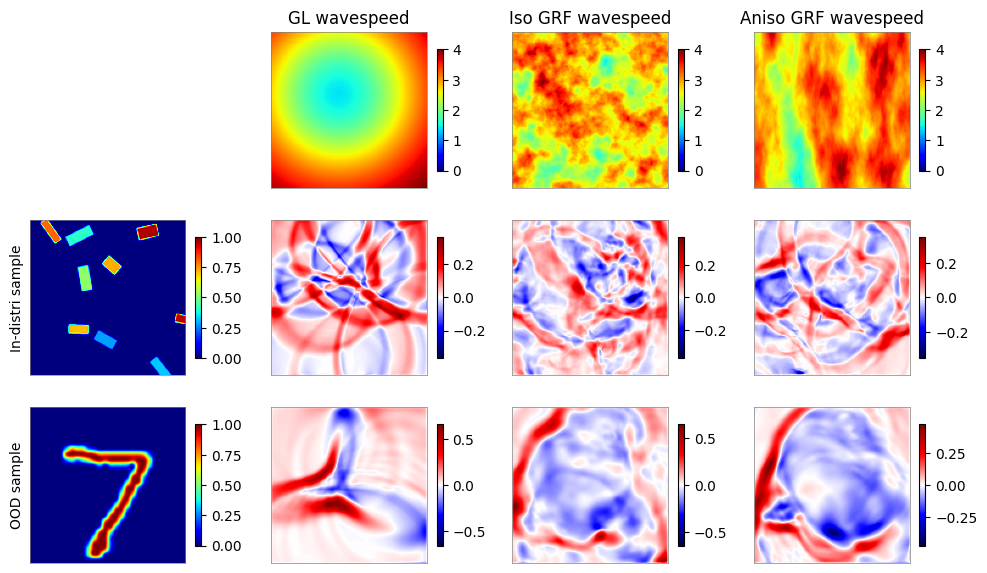

In [6]:
nrows = 3
ncols = 4
fig_size = (10, 6)
cbar_shrink = 0.7
x_list_1st_row = [
    1e-3 * medium_collection['gaussian_lens'].squeeze(),
    1e-3 * medium_collection['grf_isotropic'].squeeze(),
    1e-3 * medium_collection['grf_anisotropic'].squeeze()
    ]

final_pressure_gl, init_pressure_gl = next(iter(in_dist_rtc_loaders['gaussian_lens']['val']))#.dataset.__getitem__(1)

final_pressure_iso, _ = next(iter(in_dist_rtc_loaders['grf_isotropic']['val']))#.dataset.__getitem__(1)

final_pressure_aniso, _ = next(iter(in_dist_rtc_loaders['grf_anisotropic']['val']))#.dataset.__getitem__(1)

x_list_2nd_row = [
    init_pressure_gl.squeeze(),
    final_pressure_gl.squeeze(),
    final_pressure_iso.squeeze(),
    final_pressure_aniso.squeeze()
]

final_pressure_gl, init_pressure_gl = next(iter(ood_rtc_loaders['gaussian_lens']))#.dataset.__getitem__(1)

final_pressure_iso, _ = next(iter(ood_rtc_loaders['grf_isotropic']))#.dataset.__getitem__(1)

final_pressure_aniso, _ = next(iter(ood_rtc_loaders['grf_anisotropic']))#.dataset.__getitem__(1)


x_list_3rd_row = [
    init_pressure_gl.squeeze(),
    final_pressure_gl.squeeze(),
    final_pressure_iso.squeeze(),
    final_pressure_aniso.squeeze()]

x_list = x_list_1st_row + x_list_2nd_row + x_list_3rd_row

for i in range(len(x_list)):
    x_list[i] = np.asarray(x_list[i])

fig = plt.figure()
fig.set_size_inches(fig_size)
axes = fig.subplots(nrows, ncols)
im = np.empty(axes.shape, dtype=object)


vrange_ = [(-np.max(np.abs(x)), np.max(np.abs(x)) ) for x in x_list]


for i, (x, ax_, v) in enumerate(zip(x_list, axes.flat[1:], vrange_)):
    if i < 4 or i == 7:
        im_, _ = plot_image(x, ax=ax_, vmin=0, vmax=v[1], cmap='jet')
    else:
        im_, _ = plot_image(x, ax=ax_, vmin=v[0], vmax=v[1], cmap='seismic')
    im.flat[i] = im_
    fig.colorbar(im_, ax=ax_, shrink=cbar_shrink)

axes[0, 0].remove()

axes[0, 1].set_title("GL wavespeed")

axes[0, 2].set_title("Iso GRF wavespeed")

axes[0, 3].set_title("Aniso GRF wavespeed")

axes[1, 0].set_ylabel("In-distri sample")
axes[2, 0].set_ylabel("OOD sample")


[remove_ticks(ax) for ax in axes.flatten()]
fig.tight_layout()
plt.savefig(f"{save_path}/rtc_demo.pdf", format="pdf", bbox_inches="tight")

## Inverse Source (IS) dataset

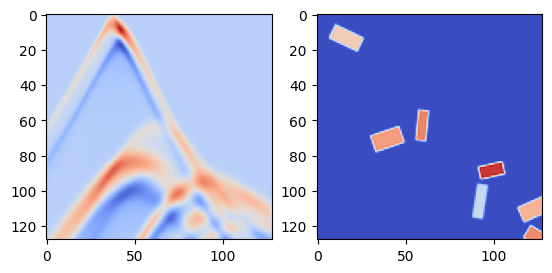

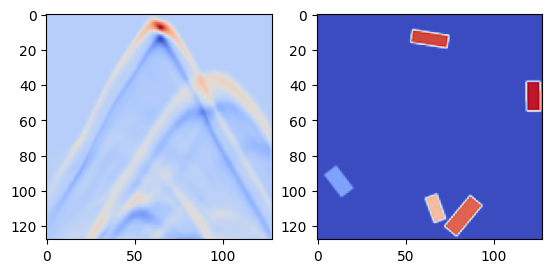

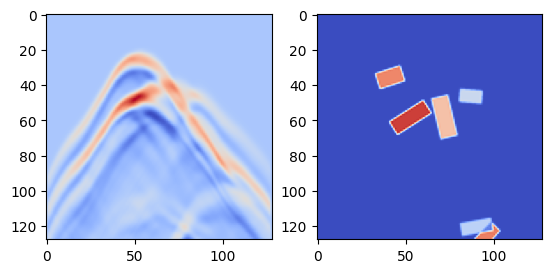

In [7]:
from wavebench.dataloaders.is_loader import get_dataloaders_is_thick_lines, get_dataloaders_is_mnist
import matplotlib.pyplot as plt


in_dist_is_loaders = {}
ood_is_loaders = {}

for medium_type in ['gaussian_lens', 'grf_isotropic', 'grf_anisotropic']:
  loaders = get_dataloaders_is_thick_lines(
    medium_type=medium_type,
  )

  idx = 4
  a, b = next(iter(loaders['train'])) #.dataset.__getitem__(idx)


  fig, axes = plt.subplots(1, 2)

  axes[0].imshow(a.squeeze().numpy(), cmap='coolwarm')
  axes[1].imshow(b.squeeze().numpy(), cmap='coolwarm')

  in_dist_is_loaders[medium_type] = loaders
  ood_is_loaders[medium_type] = get_dataloaders_is_mnist(
    medium_type)


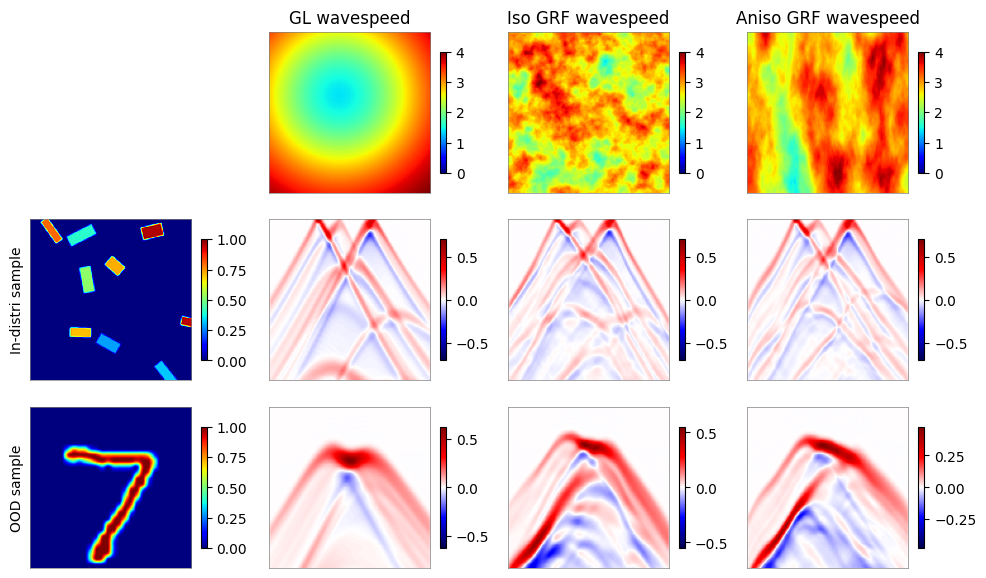

In [8]:
nrows = 3
ncols = 4
fig_size = (10, 6)
cbar_shrink = 0.7
x_list_1st_row = [
    1e-3 * medium_collection['gaussian_lens'].squeeze(),
    1e-3 * medium_collection['grf_isotropic'].squeeze(),
    1e-3 * medium_collection['grf_anisotropic'].squeeze()
    ]

final_pressure_gl, init_pressure_gl = next(iter(in_dist_is_loaders['gaussian_lens']['val']))#.dataset.__getitem__(1)

final_pressure_iso, _ = next(iter(in_dist_is_loaders['grf_isotropic']['val']))#.dataset.__getitem__(1)

final_pressure_aniso, _ = next(iter(in_dist_is_loaders['grf_anisotropic']['val']))#.dataset.__getitem__(1)

x_list_2nd_row = [
    init_pressure_gl.squeeze(),
    final_pressure_gl.squeeze(),
    final_pressure_iso.squeeze(),
    final_pressure_aniso.squeeze()
]

final_pressure_gl, init_pressure_gl = next(iter(ood_is_loaders['gaussian_lens']))#.dataset.__getitem__(1)

final_pressure_iso, _ = next(iter(ood_is_loaders['grf_isotropic']))#.dataset.__getitem__(1)

final_pressure_aniso, _ = next(iter(ood_is_loaders['grf_anisotropic']))#.dataset.__getitem__(1)


x_list_3rd_row = [
    init_pressure_gl.squeeze(),
    final_pressure_gl.squeeze(),
    final_pressure_iso.squeeze(),
    final_pressure_aniso.squeeze()]

x_list = x_list_1st_row + x_list_2nd_row + x_list_3rd_row

for i in range(len(x_list)):
    x_list[i] = np.asarray(x_list[i])

fig = plt.figure()
fig.set_size_inches(fig_size)
axes = fig.subplots(nrows, ncols)
im = np.empty(axes.shape, dtype=object)


vrange_ = [(-np.max(np.abs(x)), np.max(np.abs(x)) ) for x in x_list]


for i, (x, ax_, v) in enumerate(zip(x_list, axes.flat[1:], vrange_)):
    if i < 4 or i == 7:
        im_, _ = plot_image(x, ax=ax_, vmin=0, vmax=v[1], cmap='jet')
    else:
        im_, _ = plot_image(x, ax=ax_, vmin=v[0], vmax=v[1], cmap='seismic')
    im.flat[i] = im_
    fig.colorbar(im_, ax=ax_, shrink=cbar_shrink)

axes[0, 0].remove()

axes[0, 1].set_title("GL wavespeed")

axes[0, 2].set_title("Iso GRF wavespeed")

axes[0, 3].set_title("Aniso GRF wavespeed")

axes[1, 0].set_ylabel("In-distri sample")
axes[2, 0].set_ylabel("OOD sample")


[remove_ticks(ax) for ax in axes.flatten()]
fig.tight_layout()
plt.savefig(f"{save_path}/is_demo.pdf", format="pdf", bbox_inches="tight")